<a href="https://colab.research.google.com/github/anas-1111/rf-headpose-detection/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
# !pip install mediapipe opencv-python kaggle


In [ ]:

# Import libraries
import numpy as np
import cv2
import math
import glob
import random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from google.colab import files
import requests
from io import BytesIO
import mediapipe as mp
import zipfile
import kagglehub
import os
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
mp_drawing = mp.solutions.drawing_utils
face_module = mp.solutions.face_mesh

In [ ]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    yaw = -yaw
    if tdx is not None and tdy is not None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)
    return img

In [ ]:
def map_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [ ]:
def preprocess(face, width=450, height=450):
    x_val = [lm.x * width for lm in face.landmark]
    y_val = [lm.y * height for lm in face.landmark]
    x_val = np.array(x_val) - np.mean(x_val[1])
    y_val = np.array(y_val) - np.mean(y_val[1])
    x_val = x_val / x_val.max() if x_val.max() != 0 else x_val
    y_val = y_val / y_val.max() if y_val.max() != 0 else y_val
    return np.concatenate([x_val, y_val])

In [ ]:
dataset_path = kagglehub.dataset_download('mohamedadlyi/aflw2000-3d')
print(f"Dataset downloaded to: {dataset_path}")

Using Colab cache for faster access to the 'aflw2000-3d' dataset.
Dataset downloaded to: /kaggle/input/aflw2000-3d


In [ ]:
mat_dir = "aflw2000-3d/AFLW2000"

In [ ]:
if os.path.isdir(dataset_path):
    extracted_path = os.path.join(dataset_path, "AFLW2000")
    if os.path.exists(extracted_path):
        mat_dir = extracted_path
        print(f"Dataset already extracted and found at: {mat_dir}")
    else:
        print(f"AFLW2000 directory not found within {dataset_path}. Please check the dataset structure.")
        zip_files = glob.glob(os.path.join(dataset_path, '*.zip'))
        if zip_files:
            zip_path = zip_files[0]
            print(f"Found zip file within the downloaded directory: {zip_path}. Extracting...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall("aflw2000-3d")
            if os.path.exists(mat_dir):
                print(f"Dataset extracted to: {mat_dir}")
            else:
                print("Extraction failed or AFLW2000 not in expected location after extraction.")
                raise FileNotFoundError("Dataset not found or extracted correctly.")
        else:
             raise FileNotFoundError(f"Dataset not found or extracted correctly. No zip found in {dataset_path}")

elif os.path.isfile(dataset_path) and dataset_path.endswith('.zip'):
    print(f"Dataset is a zip file. Extracting to {mat_dir}...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("aflw2000-3d")
    if os.path.exists(mat_dir):
        print(f"Dataset extracted to: {mat_dir}")
    else:
        print("Extraction failed or AFLW2000 not in expected location after extraction.")
        raise FileNotFoundError("Dataset not found or extracted correctly.")
else:
    raise FileNotFoundError(f"Downloaded dataset path is not a directory or a zip file: {dataset_path}")


Dataset already extracted and found at: /kaggle/input/aflw2000-3d/AFLW2000


In [ ]:
if os.path.isdir(dataset_path):
    extracted_path = os.path.join(dataset_path, "AFLW2000")
    if os.path.exists(extracted_path):
        mat_dir = extracted_path
        print(f"Dataset already extracted and found at: {mat_dir}")
    else:
        print(f"AFLW2000 directory not found within {dataset_path}. Please check the dataset structure.")
        zip_files = glob.glob(os.path.join(dataset_path, '*.zip'))
        if zip_files:
            zip_path = zip_files[0]
            print(f"Found zip file within the downloaded directory: {zip_path}. Extracting...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall("aflw2000-3d")
            if os.path.exists(mat_dir):
                print(f"Dataset extracted to: {mat_dir}")
            else:
                print("Extraction failed or AFLW2000 not in expected location after extraction.")
                raise FileNotFoundError("Dataset not found or extracted correctly.")
        else:
             raise FileNotFoundError(f"Dataset not found or extracted correctly. No zip found in {dataset_path}")

elif os.path.isfile(dataset_path) and dataset_path.endswith('.zip'):
    print(f"Dataset is a zip file. Extracting to {mat_dir}...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("aflw2000-3d")
    if os.path.exists(mat_dir):
        print(f"Dataset extracted to: {mat_dir}")
    else:
        print("Extraction failed or AFLW2000 not in expected location after extraction.")
        raise FileNotFoundError("Dataset not found or extracted correctly.")
else:
    raise FileNotFoundError(f"Downloaded dataset path is not a directory or a zip file: {dataset_path}")


Dataset already extracted and found at: /kaggle/input/aflw2000-3d/AFLW2000


In [ ]:
pose_data = []
landmarks_data = []

with face_module.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
    for fname in os.listdir(mat_dir):
        if fname.endswith('.mat'):
            image_id = fname.replace('.mat', '')
            mat_path = os.path.join(mat_dir, fname)
            img_path = os.path.join(mat_dir, image_id + '.jpg')

            if not os.path.exists(img_path):
                continue

            mat = sio.loadmat(mat_path)
            pose = mat["Pose_Para"][0][:3]
            pitch, yaw, roll = map_to_pi(pose[0]), map_to_pi(pose[1]), map_to_pi(pose[2])
            pose_data.append([image_id, pitch, yaw, roll])

            image = cv2.imread(img_path)
            if image is None:
                continue
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_image)

            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = preprocess(face_landmarks, image.shape[1], image.shape[0])
                landmarks_data.append([image_id, landmarks])


In [ ]:
df = pd.DataFrame(pose_data, columns=["image_id", "pitch", "yaw", "roll"])
landmarks_df = pd.DataFrame(landmarks_data, columns=["image_id", "marks_values"])
final_df = pd.merge(df, landmarks_df, on="image_id", how="inner")

In [ ]:
X = np.array(final_df['marks_values'].to_list())
y = np.array(final_df[['pitch', 'yaw', 'roll']])
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1853, 936), y shape: (1853, 3)


In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, range(len(X)), test_size=0.2, random_state=42)

print(f"Data split successfully.")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
print(f"train_indices length: {len(train_indices)}, test_indices length: {len(test_indices)}")

Data split successfully.
X_train shape: (1482, 936), X_test shape: (371, 936)
y_train shape: (1482, 3), y_test shape: (371, 3)
train_indices length: 1482, test_indices length: 371


In [ ]:
# Select top 10 features for pitch
selector_pitch = SelectKBest(score_func=f_regression, k=10)
selector_pitch.fit(X_train, y_train[:, 0])
pitch_features_indices = selector_pitch.get_support(indices=True)
print(f"Top 10 feature indices for Pitch: {pitch_features_indices}")

# Select top 10 features for yaw
selector_yaw = SelectKBest(score_func=f_regression, k=10)
selector_yaw.fit(X_train, y_train[:, 1])
yaw_features_indices = selector_yaw.get_support(indices=True)
print(f"Top 10 feature indices for Yaw: {yaw_features_indices}")

# Select top 10 features for roll
selector_roll = SelectKBest(score_func=f_regression, k=10)
selector_roll.fit(X_train, y_train[:, 2])
roll_features_indices = selector_roll.get_support(indices=True)
print(f"Top 10 feature indices for Roll: {roll_features_indices}")

Top 10 feature indices for Pitch: [819 825 880 881 882 885 921 931 932 933]
Top 10 feature indices for Yaw: [ 83  84  85 148 171 181 201 208 274 275]
Top 10 feature indices for Roll: [512 705 742 884 895 898 900 902 904 925]


In [ ]:
# Create pitch datasets with selected features
X_train_pitch = X_train[:, pitch_features_indices]
X_test_pitch = X_test[:, pitch_features_indices]
y_train_pitch = y_train[:, 0]
y_test_pitch = y_test[:, 0]

# Create yaw datasets with selected features
X_train_yaw = X_train[:, yaw_features_indices]
X_test_yaw = X_test[:, yaw_features_indices]
y_train_yaw = y_train[:, 1]
y_test_yaw = y_test[:, 1]

# Create roll datasets with selected features
X_train_roll = X_train[:, roll_features_indices]
X_test_roll = X_test[:, roll_features_indices]
y_train_roll = y_train[:, 2]
y_test_roll = y_test[:, 2]

print(f"Pitch datasets shape: X_train_pitch {X_train_pitch.shape}, X_test_pitch {X_test_pitch.shape}, y_train_pitch {y_train_pitch.shape}, y_test_pitch {y_test_pitch.shape}")
print(f"Yaw datasets shape: X_train_yaw {X_train_yaw.shape}, X_test_yaw {X_test_yaw.shape}, y_train_yaw {y_train_yaw.shape}, y_test_yaw {y_test_yaw.shape}")
print(f"Roll datasets shape: X_train_roll {X_train_roll.shape}, X_test_roll {X_test_roll.shape}, y_train_roll {y_train_roll.shape}, y_test_roll {y_test_roll.shape}")

Pitch datasets shape: X_train_pitch (1482, 10), X_test_pitch (371, 10), y_train_pitch (1482,), y_test_pitch (371,)
Yaw datasets shape: X_train_yaw (1482, 10), X_test_yaw (371, 10), y_train_yaw (1482,), y_test_yaw (371,)
Roll datasets shape: X_train_roll (1482, 10), X_test_roll (371, 10), y_train_roll (1482,), y_test_roll (371,)


In [ ]:
# Instantiate and train the Random Forest model for pitch
rf_pitch = RandomForestRegressor(random_state=42)
rf_pitch.fit(X_train_pitch, y_train_pitch)

# Instantiate and train the Random Forest model for yaw
rf_yaw = RandomForestRegressor(random_state=42)
rf_yaw.fit(X_train_yaw, y_train_yaw)

# Instantiate and train the Random Forest model for roll
rf_roll = RandomForestRegressor(random_state=42)
rf_roll.fit(X_train_roll, y_train_roll)

print("Random Forest models trained successfully for Pitch, Yaw, and Roll.")

Random Forest models trained successfully for Pitch, Yaw, and Roll.


In [ ]:
# Predict the pitch angles using the trained rf_pitch model
pitch_predictions = rf_pitch.predict(X_test_pitch)

# Calculate the MSE and R² score for the pitch predictions
mse_pitch = mean_squared_error(y_test_pitch, pitch_predictions)
r2_pitch = r2_score(y_test_pitch, pitch_predictions)

# Predict the yaw angles using the trained rf_yaw model
yaw_predictions = rf_yaw.predict(X_test_yaw)

# Calculate the MSE and R² score for the yaw predictions
mse_yaw = mean_squared_error(y_test_yaw, yaw_predictions)
r2_yaw = r2_score(y_test_yaw, yaw_predictions)

# Predict the roll angles using the trained rf_roll model
roll_predictions = rf_roll.predict(X_test_roll)

# Calculate the MSE and R² score for the roll predictions
mse_roll = mean_squared_error(y_test_roll, roll_predictions)
r2_roll = r2_score(y_test_roll, roll_predictions)

# Print the calculated MSE and R² scores for each angle
print(f'Pitch - Mean Squared Error: {mse_pitch:.4f}, R² Score: {r2_pitch:.4f}')
print(f'Yaw - Mean Squared Error: {mse_yaw:.4f}, R² Score: {r2_yaw:.4f}')
print(f'Roll - Mean Squared Error: {mse_roll:.4f}, R² Score: {r2_roll:.4f}')

Pitch - Mean Squared Error: 0.0746, R² Score: 0.3793
Yaw - Mean Squared Error: 0.0554, R² Score: 0.8418
Roll - Mean Squared Error: 0.0936, R² Score: 0.2925


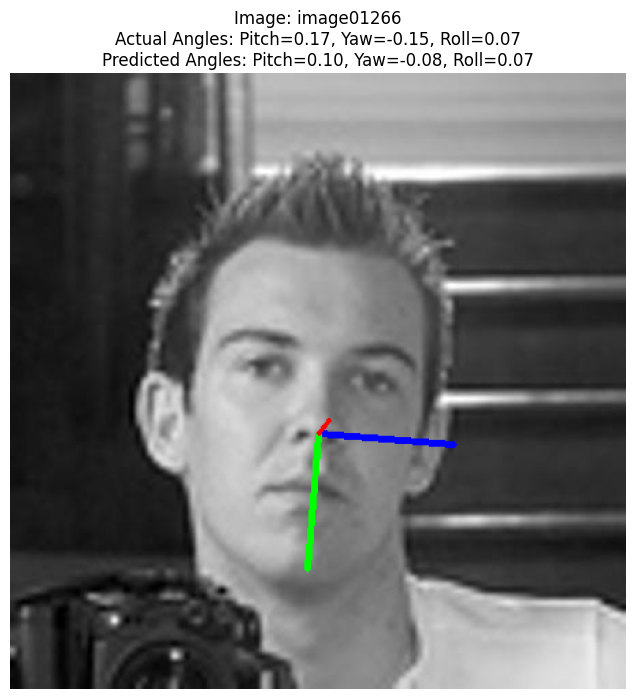

In [ ]:
# Ensure mat_dir is defined
if 'mat_dir' not in locals():
    print("Error: mat_dir not defined. Please run the data download and extraction steps.")
    # Exit or handle the error appropriately
    raise

# Ensure the models are trained
if 'rf_pitch' not in locals() or 'rf_yaw' not in locals() or 'rf_roll' not in locals():
    print("Error: Random Forest models not trained. Please train the models first.")
    raise

# Ensure feature indices are determined
if 'pitch_features_indices' not in locals() or 'yaw_features_indices' not in locals() or 'roll_features_indices' not in locals():
     print("Error: Feature indices not determined. Please run the feature selection step first.")
     raise

# Select a random index from the test set indices (obtained in a previous step)
if 'test_indices' not in locals():
     print("Error: test_indices not found. Please ensure the train_test_split was run and test_indices are available.")
     raise

random_test_index_original = random.choice(test_indices)

# Get the corresponding image_id and actual angles from the original final_df
random_image_id = final_df.loc[random_test_index_original, 'image_id']
actual_pitch = final_df.loc[random_test_index_original, 'pitch']
actual_yaw = final_df.loc[random_test_index_original, 'yaw']
actual_roll = final_df.loc[random_test_index_original, 'roll']
actual_angles = [actual_pitch, actual_yaw, actual_roll]

# Construct the image path
image_path = os.path.join(mat_dir, random_image_id + '.jpg')

# Load and process the image
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with face_module.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        # Use the preprocess function defined earlier
        marks = preprocess(face, rgb_image.shape[1], rgb_image.shape[0])

        # Extract the top 10 features for each angle
        marks_pitch = marks[pitch_features_indices].reshape(1, -1)
        marks_yaw = marks[yaw_features_indices].reshape(1, -1)
        marks_roll = marks[roll_features_indices].reshape(1, -1)

        # Make predictions using the trained models
        pred_pitch = rf_pitch.predict(marks_pitch)[0]
        pred_yaw = rf_yaw.predict(marks_yaw)[0]
        pred_roll = rf_roll.predict(marks_roll)[0]

        center = face.landmark[1] # Assuming landmark 1 is near the nose/center of the face
        tdx, tdy = int(center.x * rgb_image.shape[1]), int(center.y * rgb_image.shape[0])

        # Use the draw_axis function defined earlier
        img_with_pred = draw_axis(rgb_image.copy(), pred_pitch, pred_yaw, pred_roll, tdx, tdy)

        # Display the image with predicted pose and actual pose information
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_pred)
        plt.title(f'Image: {random_image_id}\nActual Angles: Pitch={actual_pitch:.2f}, Yaw={actual_yaw:.2f}, Roll={actual_roll:.2f}\nPredicted Angles: Pitch={pred_pitch:.2f}, Yaw={pred_yaw:.2f}, Roll={pred_roll:.2f}')
        plt.axis('off')
        plt.show()
    else:
        print(f"No face detected in image: {image_path}")

In [ ]:
uploaded_files = files.upload()

if len(uploaded_files) == 0:
    print("No file was uploaded.")
else:
    video_filename = list(uploaded_files.keys())[0]
    print(f"Uploaded file: {video_filename}")

Saving WhatsApp Video 2025-09-15 at 12.35.37_e71a8cf3.mp4 to WhatsApp Video 2025-09-15 at 12.35.37_e71a8cf3.mp4
Uploaded file: WhatsApp Video 2025-09-15 at 12.35.37_e71a8cf3.mp4


In [ ]:
cap = cv2.VideoCapture(video_filename)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_filename}")
else:
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            break

    cap.release()
    print(f"Read {len(frames)} frames from the video.")

Read 285 frames from the video.


In [ ]:
face_mesh = face_module.FaceMesh(static_image_mode=True, max_num_faces=1)
frame_landmarks_results = []

for frame in frames:
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    frame_landmarks_results.append(results)

print(f"Processed {len(frame_landmarks_results)} frames for face landmarks.")

Processed 285 frames for face landmarks.


In [ ]:
processed_landmarks_video = []

for results in frame_landmarks_results:
    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]

        image_height, image_width, _ = frames[0].shape
        marks = preprocess(face, image_width, image_height)

        marks_pitch = marks[pitch_features_indices]
        marks_yaw = marks[yaw_features_indices]
        marks_roll = marks[roll_features_indices]

        combined_features = np.concatenate([marks_pitch, marks_yaw, marks_roll])
        processed_landmarks_video.append(combined_features)
    else:
        processed_landmarks_video.append(None)

print(f"Processed {len(processed_landmarks_video)} frames for feature extraction.")
if processed_landmarks_video:
    first_valid_features = next((item for item in processed_landmarks_video if item is not None), None)
    if first_valid_features is not None:
        print(f"Shape of the first valid feature vector: {first_valid_features.shape}")
    else:
        print("No valid face landmarks were detected in any frame.")


Processed 285 frames for feature extraction.
Shape of the first valid feature vector: (30,)


In [ ]:
predicted_poses_video = []

for features in processed_landmarks_video:
    if features is not None:
        marks_pitch = features[:10].reshape(1, -1)
        marks_yaw = features[10:20].reshape(1, -1)
        marks_roll = features[20:].reshape(1, -1)

        pred_pitch = rf_pitch.predict(marks_pitch)[0]
        pred_yaw = rf_yaw.predict(marks_yaw)[0]
        pred_roll = rf_roll.predict(marks_roll)[0]

        predicted_poses_video.append([pred_pitch, pred_yaw, pred_roll])
    else:
        predicted_poses_video.append(None)

valid_predictions_count = sum(1 for item in predicted_poses_video if item is not None)
print(f"Number of frames with predicted poses: {valid_predictions_count}")

Number of frames with predicted poses: 263


In [ ]:
output_frames = []

for i, (frame, predicted_pose) in enumerate(zip(frames, predicted_poses_video)):
    if predicted_pose is not None:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        pred_pitch, pred_yaw, pred_roll = predicted_pose

        face_results = frame_landmarks_results[i]
        if face_results.multi_face_landmarks:
            face = face_results.multi_face_landmarks[0]
            center = face.landmark[1]
            tdx, tdy = int(center.x * rgb_frame.shape[1]), int(center.y * rgb_frame.shape[0])

            img_with_pred = draw_axis(rgb_frame.copy(), pred_pitch, pred_yaw, pred_roll, tdx, tdy)
            output_frames.append(img_with_pred)
        else:
            output_frames.append(frame.copy())
    else:
        output_frames.append(frame.copy())

visualized_frames_count = sum(1 for i, predicted_pose in enumerate(predicted_poses_video) if predicted_pose is not None and frame_landmarks_results[i].multi_face_landmarks)

print(f"Number of frames with visualizations: {visualized_frames_count}")

Number of frames with visualizations: 263


In [ ]:
output_video_filename = "output_pose_video.mp4"

cap_props = cv2.VideoCapture(video_filename)
if not cap_props.isOpened():
    print(f"Error: Could not open video file {video_filename} to get properties.")
    frame_width = output_frames[0].shape[1] if output_frames else 640
    frame_height = output_frames[0].shape[0] if output_frames else 480
    fps = 30
else:
    frame_width = int(cap_props.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap_props.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap_props.get(cv2.CAP_PROP_FPS))
    cap_props.release()

print(f"Original video properties: Width={frame_width}, Height={frame_height}, FPS={fps}")

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_filename, fourcc, fps, (frame_width, frame_height))

for frame in output_frames:

    if len(frame.shape) == 3 and frame.shape[2] == 3:
        frame_to_write = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    else:
        frame_to_write = frame
    out.write(frame_to_write)

out.release()

print(f"Video saved as {output_video_filename}")

files.download(output_video_filename)

Original video properties: Width=478, Height=850, FPS=29
Video saved as output_pose_video.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_filename_pitch = "rf_pitch_model.pkl"
model_filename_yaw = "rf_yaw_model.pkl"
model_filename_roll = "rf_roll_model.pkl"

with open(model_filename_pitch, 'wb') as f:
    pickle.dump(rf_pitch, f)

with open(model_filename_yaw, 'wb') as f:
    pickle.dump(rf_yaw, f)

with open(model_filename_roll, 'wb') as f:
    pickle.dump(rf_roll, f)

print(f"Random Forest models saved as {model_filename_pitch}, {model_filename_yaw}, and {model_filename_roll}")

Random Forest models saved as rf_pitch_model.pkl, rf_yaw_model.pkl, and rf_roll_model.pkl


In [ ]:
# Download the saved model files
files.download(model_filename_pitch)
files.download(model_filename_yaw)
files.download(model_filename_roll)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>